数据集为： (200, 3)


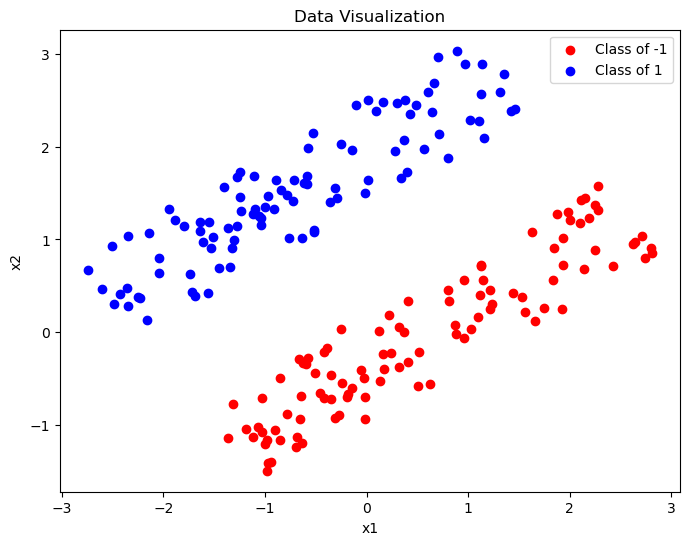

SMO Iteration:   3%|▎         | 33/1000 [00:00<00:01, 517.26it/s]

支持向量的索引： [ 15  20  37  41  46  51  97  99 130 132 143 149 159 162 183 190 195]
支持向量的个数： 17
w: [-0.98394334  1.52969703]
b: -1.1731302912637032
支持向量机的决策函数：w*x + b = 0


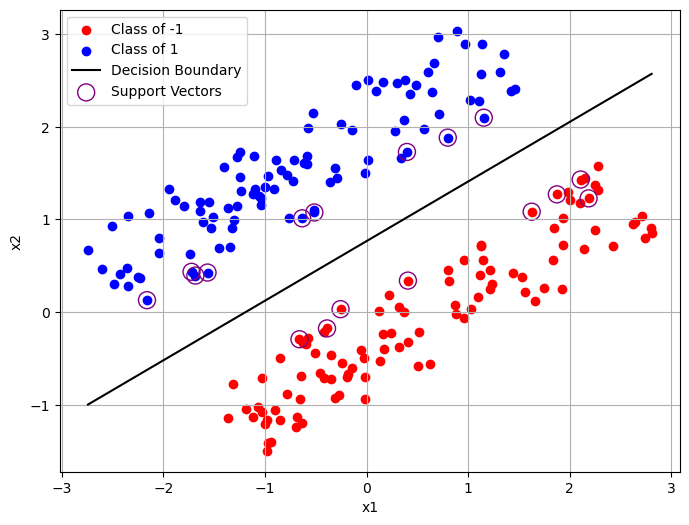

In [ ]:

import numpy as np
import matplotlib.pyplot as plt      
from matplotlib.colors import ListedColormap
from tqdm import tqdm, trange

data=np.loadtxt('linear.csv', delimiter=',')
print("数据集为：",data.shape)
x=data[:,0:2]
y=data[:,2]
#print(x.shape, y.shape)

#数据集可视化
plt.figure(figsize=(8, 6))
plt.scatter(x[y==-1,0], x[y==-1,1], color='red', label='Class of -1')
plt.scatter(x[y==1,0], x[y==1,1], color='blue', label='Class of 1')
plt.title('Data Visualization')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

def SMO(x, y, ker, C, max_iter, tol=1e-3):
    # 参数含义
    # x: 输入特征
    # y: 标签
    # ker: 核函数
    # C: 惩罚参数
    # max_iter: 最大迭代次数
    # tol: 容忍度
    
    # 初始化参数
    m = x.shape[0]
    alpha = np.zeros(m)
    b = 0.0
    
    # 预计算核矩阵
    K = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            K[i, j] = ker(x[i], x[j])
            
    for _ in trange(max_iter, desc="SMO Iteration"):
        alpha_changed_count = 0
        for i in range(m):
            # 计算预测值 f(xi) 和误差 Ei
            # f(xi) = sum(alpha_k * y_k * K(xk, xi)) + b
            f_xi = np.sum(alpha * y * K[:, i]) + b
            Ei = f_xi - y[i]
            
            # 检查 alpha[i] 是否违反 KKT 条件
            if (y[i] * Ei < -tol and alpha[i] < C) or \
               (y[i] * Ei > tol and alpha[i] > 0):
                
                # 随机选择 j != i
                j = np.random.choice([l for l in range(m) if l != i])
                
                # 计算预测值 f(xj) 和误差 Ej
                f_xj = np.sum(alpha * y * K[:, j]) + b
                Ej = f_xj - y[j]
                
                # 保存旧的 alpha 值
                alpha_i_old, alpha_j_old = alpha[i], alpha[j]
                
                # 计算 L 和 H (alpha_j 的裁剪边界)
                if y[i] != y[j]:
                    L = max(0, alpha[j] - alpha[i])
                    H = min(C, C + alpha[j] - alpha[i])
                else:
                    L = max(0, alpha[i] + alpha[j] - C)
                    H = min(C, alpha[i] + alpha[j])
                
                if L == H:
                    continue
                    
                # 计算 eta
                eta = 2 * K[i, j] - K[i, i] - K[j, j]
                if eta >= 0:
                    continue
                
                # 更新 alpha[j] 并进行裁剪
                alpha[j] -= y[j] * (Ei - Ej) / eta
                alpha[j] = np.clip(alpha[j], L, H)
                
                # 如果 alpha[j] 的变化太小，则忽略
                if abs(alpha[j] - alpha_j_old) < 1e-5:
                    continue
                
                # 更新 alpha[i]
                alpha[i] += y[i] * y[j] * (alpha_j_old - alpha[j])
                
                # 更新偏置项 b
                b1 = b - Ei - y[i] * (alpha[i] - alpha_i_old) * K[i, i] - \
                     y[j] * (alpha[j] - alpha_j_old) * K[i, j]
                b2 = b - Ej - y[i] * (alpha[i] - alpha_i_old) * K[i, j] - \
                     y[j] * (alpha[j] - alpha_j_old) * K[j, j]
                
                if 0 < alpha[i] < C:
                    b = b1
                elif 0 < alpha[j] < C:
                    b = b2
                else:
                    b = (b1 + b2) / 2
                
                alpha_changed_count += 1
        
        # 如果一轮迭代下来 alpha 没有变化，可以提前终止
        if alpha_changed_count == 0:
            break
            
    return alpha, b

#设置超参数
C=1.0 # 使用一个更常规的C值
max_iter=1000
np.random.seed(0)

alpha, b = SMO(x, y, ker=np.inner, C=C, max_iter=max_iter)

sup_idx=alpha > 1e-5
print("支持向量的索引：", np.where(sup_idx)[0])
print("支持向量的个数：", np.sum(sup_idx))

w=np.sum((alpha[sup_idx]*y[sup_idx]).reshape(-1, 1) * x[sup_idx], axis=0)
print("w:", w)
print("b:", b)
print("支持向量机的决策函数：w*x + b = 0")

# --- 修正绘图部分 ---
# 创建一个 x1 坐标范围
X = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 100)
# 根据决策边界方程 w0*x1 + w1*x2 + b = 0 计算对应的 x2 (即 Y)
Y = (-w[0] * X - b) / (w[1] + 1e-5)  # 避免除以0

plt.figure(figsize=(8, 6))
plt.scatter(x[y==-1,0],x[y==-1,1],color='red',label='Class of -1' )
plt.scatter(x[y==1,0],x[y==1,1],color='blue',label='Class of 1')
plt.plot(X,Y,color='black',label='Decision Boundary')

#标记出支持向量
plt.scatter(x[sup_idx,0],x[sup_idx,1],marker='o',color='none',edgecolors='purple',s=150,label='Support Vectors')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid(True)
plt.show()

